# Bank Marketing: Business Analytics & Machine Learning

Predict customer subscription propensity using supervised learning, with evaluation focused on business-relevant metrics.


In [1]:
# Setup
import os
import zipfile
import warnings
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from IPython.display import display

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, learning_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance

warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Create folders
DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)
FIG_DIR = Path("figures")
FIG_DIR.mkdir(exist_ok=True)

print("Ready ")

Ready 


In [2]:
# Download dataset

import requests

ZIP_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"
ZIP_PATH = DATA_DIR / "bank-additional.zip"
CSV_IN_ZIP = "bank-additional/bank-additional-full.csv"  # path inside zip

def download_file(url: str, dst: Path, timeout: int = 60) -> None:
    if dst.exists() and dst.stat().st_size > 0:
        print(f"Already exists: {dst} ({dst.stat().st_size/1024:.1f} KB)")
        return
    print(f"Downloading: {url}")
    r = requests.get(url, timeout=timeout)
    r.raise_for_status()
    dst.write_bytes(r.content)
    print(f"Saved to: {dst} ({dst.stat().st_size/1024:.1f} KB)")

download_file(ZIP_URL, ZIP_PATH)

# Validate ZIP
with zipfile.ZipFile(ZIP_PATH, "r") as z:
    names = z.namelist()
    print("Zip contains (first 10):", names[:10])
    assert CSV_IN_ZIP in names, f"Expected {CSV_IN_ZIP} not found. Found: {names[:20]}"
    print(" Found:", CSV_IN_ZIP)

Already exists: data\bank-additional.zip (434.2 KB)
Zip contains (first 10): ['bank-additional/', 'bank-additional/.DS_Store', '__MACOSX/', '__MACOSX/bank-additional/', '__MACOSX/bank-additional/._.DS_Store', 'bank-additional/.Rhistory', 'bank-additional/bank-additional-full.csv', 'bank-additional/bank-additional-names.txt', 'bank-additional/bank-additional.csv', '__MACOSX/._bank-additional']
 Found: bank-additional/bank-additional-full.csv


In [3]:
# Load data
with zipfile.ZipFile(ZIP_PATH, "r") as z:
    with z.open(CSV_IN_ZIP) as f:
        df = pd.read_csv(f, sep=";")

df.head(), df.shape

(   age        job  marital    education  default housing loan    contact  \
 0   56  housemaid  married     basic.4y       no      no   no  telephone   
 1   57   services  married  high.school  unknown      no   no  telephone   
 2   37   services  married  high.school       no     yes   no  telephone   
 3   40     admin.  married     basic.6y       no      no   no  telephone   
 4   56   services  married  high.school       no      no  yes  telephone   
 
   month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
 0   may         mon  ...         1    999         0  nonexistent          1.1   
 1   may         mon  ...         1    999         0  nonexistent          1.1   
 2   may         mon  ...         1    999         0  nonexistent          1.1   
 3   may         mon  ...         1    999         0  nonexistent          1.1   
 4   may         mon  ...         1    999         0  nonexistent          1.1   
 
    cons.price.idx  cons.conf.idx  euribor

## Data Loading & Basic Checks
Load the dataset and inspect structure, data types, missing values, and target balance.


In [4]:
# Duplicates
dup_count = df.duplicated().sum()
print("Duplicates:", dup_count)

# Missing values (true NaNs)
na_counts = df.isna().sum().sort_values(ascending=False)
display(na_counts.head(10))

# Target distribution
target_col = "y"
print(df[target_col].value_counts())
print("\nChurn/Response rate (y='yes'):", (df[target_col] == "yes").mean().round(4))

# Data types
display(df.dtypes)

# Quick stats for numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
display(df[num_cols].describe().T)

Duplicates: 12


age               0
campaign          0
nr.employed       0
euribor3m         0
cons.conf.idx     0
cons.price.idx    0
emp.var.rate      0
poutcome          0
previous          0
pdays             0
dtype: int64

y
no     36548
yes     4640
Name: count, dtype: int64

Churn/Response rate (y='yes'): 0.1127


age                 int64
job                   str
marital               str
education             str
default               str
housing               str
loan                  str
contact               str
month                 str
day_of_week           str
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome              str
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                     str
dtype: object

,count,mean,std,min,25%,50%,75%,max
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000
duration,41188.0,258.285010,259.279249,0.000,102.000,180.000,319.000,4918.000
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000
pdays,41188.0,962.475454,186.910907,0.000,999.000,999.000,999.000,999.000
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000
emp.var.rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
nr.employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100


## Feature Prep
Light wrangling to standardize columns and prepare the target label for modeling.


In [5]:
# Clean column names
df = df.copy()
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Target: yes/no -> 1/0
df["y"] = (df["y"].str.lower() == "yes").astype(int)

# Separate features/target
X = df.drop(columns=["y"])
y = df["y"]

# Identify column types
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)
print("Shape X:", X.shape, "Target positive rate:", y.mean().round(4))

Numeric: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Categorical: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
Shape X: (41188, 20) Target positive rate: 0.1127


## Exploratory Data Analysis
Quick EDA to understand target balance and a few key relationships that inform modeling choices.


In [6]:
# Helper: target rate by category
def target_rate_by_category(df_in: pd.DataFrame, col: str, top_n: int = 12) -> pd.DataFrame:
    tmp = (
        df_in.groupby(col)["y"]
        .agg(rate="mean", count="size")
        .sort_values(["rate","count"], ascending=False)
        .reset_index()
    )
    return tmp.head(top_n)

# Top segments
for col in ["job", "marital", "education", "housing", "loan", "contact", "poutcome"]:
    if col in df.columns:
        display(target_rate_by_category(df, col, top_n=10))

,job,rate,count
0,student,0.314286,875
1,retired,0.252326,1720
2,unemployed,0.142012,1014
3,admin.,0.129726,10422
4,management,0.112175,2924
5,unknown,0.112121,330
6,technician,0.108260,6743
7,self-employed,0.104856,1421
8,housemaid,0.100000,1060
9,entrepreneur,0.085165,1456


,marital,rate,count
0,unknown,0.150000,80
1,single,0.140041,11568
2,divorced,0.103209,4612
3,married,0.101573,24928


,education,rate,count
0,illiterate,0.222222,18
1,unknown,0.145003,1731
2,university.degree,0.137245,12168
3,professional.course,0.113485,5243
4,high.school,0.108355,9515
5,basic.4y,0.102490,4176
6,basic.6y,0.082024,2292
7,basic.9y,0.078246,6045


,housing,rate,count
0,yes,0.116194,21576
1,no,0.108796,18622
2,unknown,0.108081,990


,loan,rate,count
0,no,0.113402,33950
1,yes,0.109315,6248
2,unknown,0.108081,990


,contact,rate,count
0,cellular,0.147376,26144
1,telephone,0.052313,15044


,poutcome,rate,count
0,success,0.651129,1373
1,failure,0.142286,4252
2,nonexistent,0.088322,35563


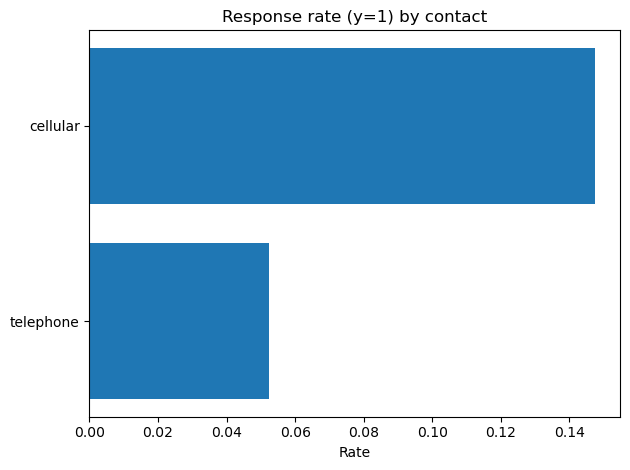

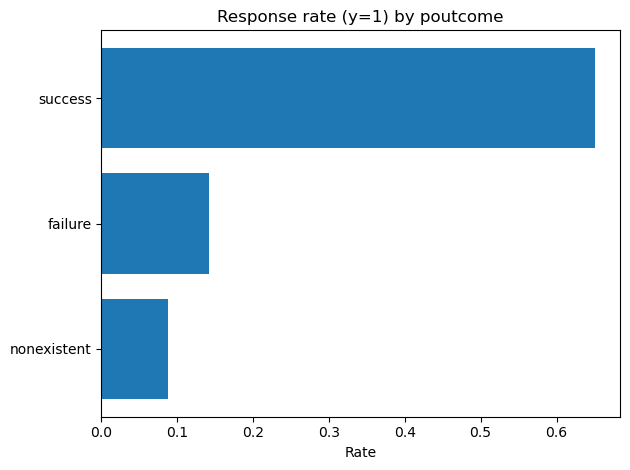

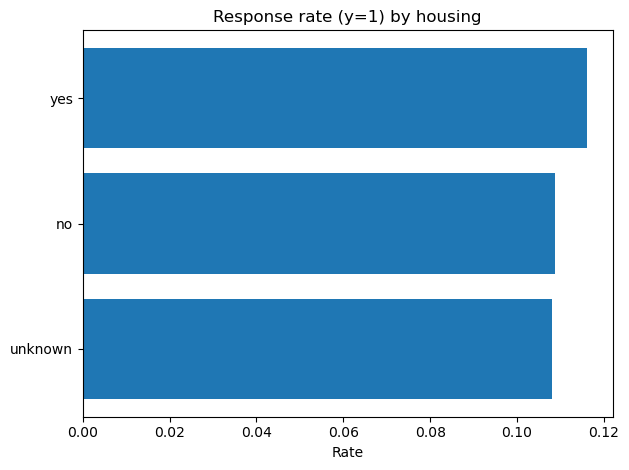

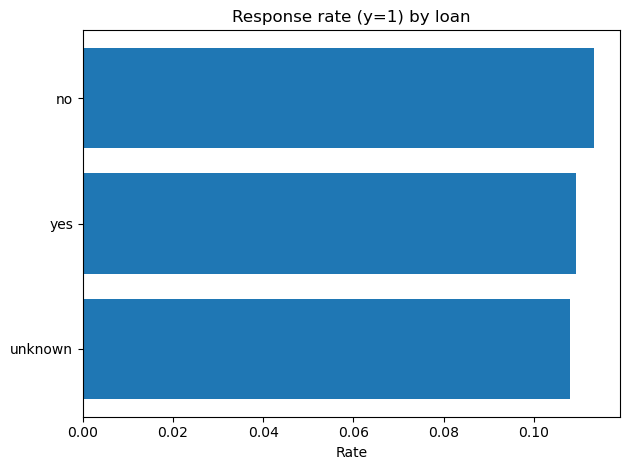

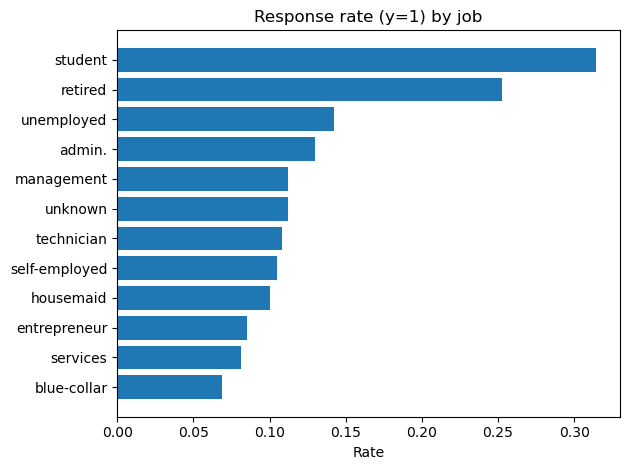

In [7]:
# Plot: response rate by selected categorical features
cats_to_plot = ["contact", "poutcome", "housing", "loan", "job"]
for col in cats_to_plot:
    if col not in df.columns: 
        continue
    tmp = target_rate_by_category(df, col, top_n=12).sort_values("rate", ascending=True)
    plt.figure()
    plt.barh(tmp[col].astype(str), tmp["rate"])
    plt.title(f"Response rate (y=1) by {col}")
    plt.xlabel("Rate")
    plt.tight_layout()
    plt.show()

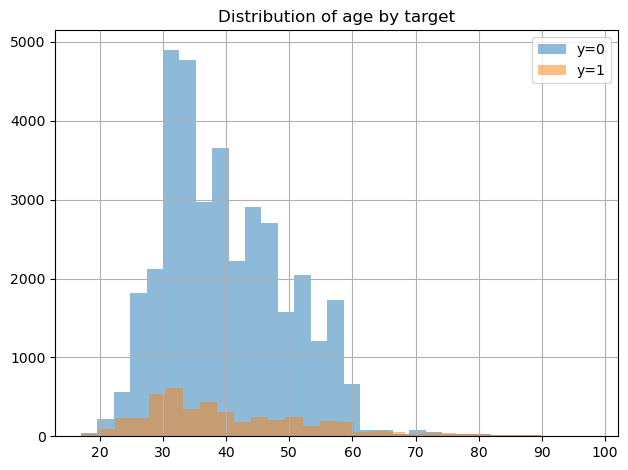

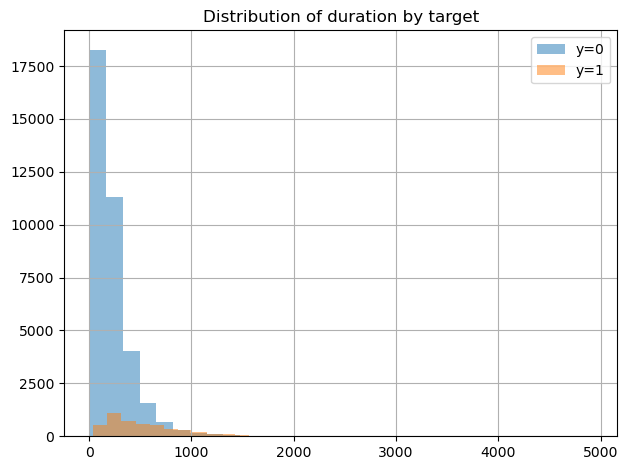

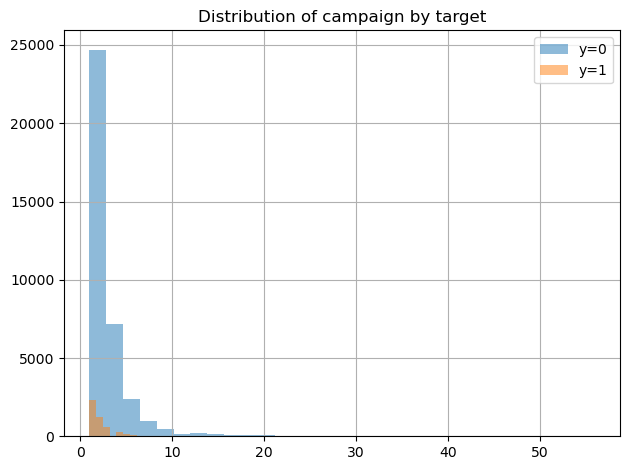

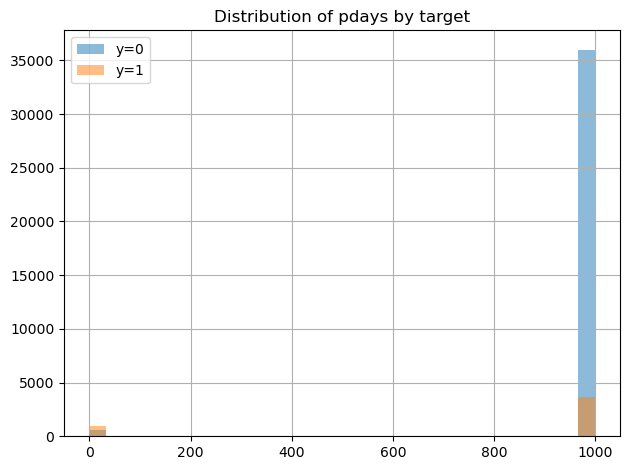

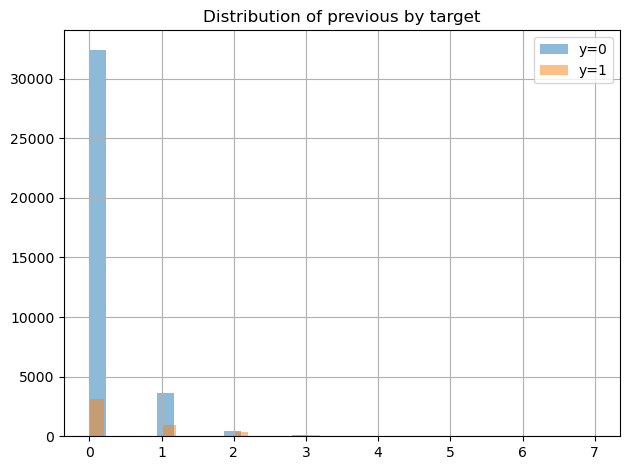

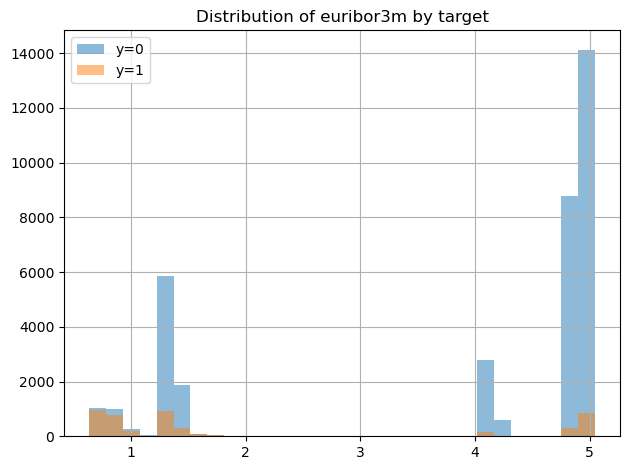

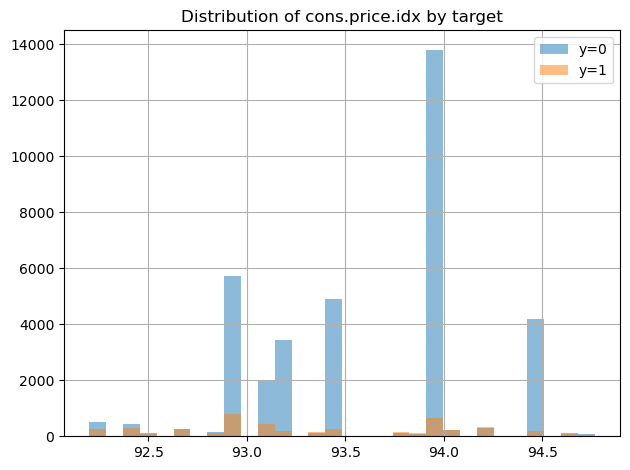

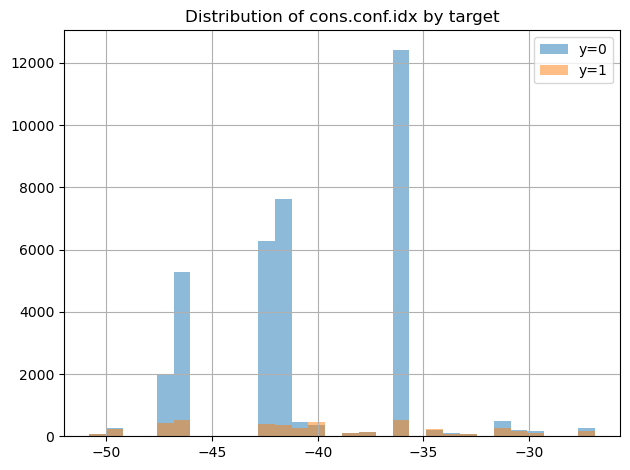

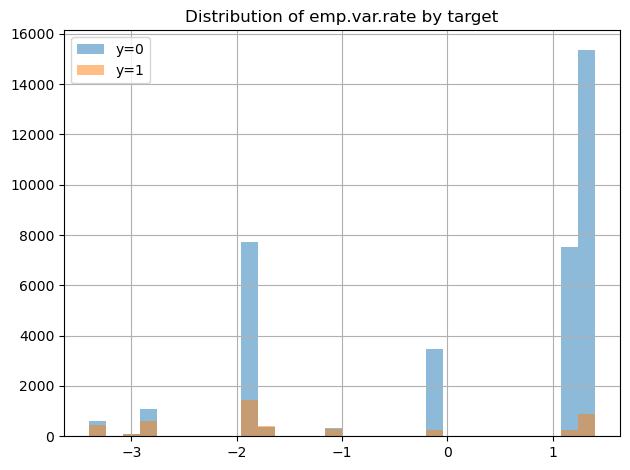

In [8]:
# Numeric distributions vs target
num_show = [c for c in ["age", "duration", "campaign", "pdays", "previous", "euribor3m", "cons.price.idx", "cons.conf.idx", "emp.var.rate"] if c in df.columns]

for col in num_show:
    plt.figure()
    df[df["y"]==0][col].hist(alpha=0.5, bins=30, label="y=0")
    df[df["y"]==1][col].hist(alpha=0.5, bins=30, label="y=1")
    plt.title(f"Distribution of {col} by target")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Preprocessing
- Train / validation / test split to prevent leakage  
- Scaling for numeric features  
- One-hot encoding for categorical variables


In [9]:
# Train/validation/test split
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=RANDOM_STATE
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("Positive rates:", y_train.mean().round(4), y_val.mean().round(4), y_test.mean().round(4))

# Preprocessing
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

preprocess

Train: (26360, 20) Val: (6590, 20) Test: (8238, 20)
Positive rates: 0.1127 0.1126 0.1126


,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``. e.g. `

## Model Comparison
Multiple models were evaluated. Selection was based on validation ROC-AUC and PR-AUC due to class imbalance.


In [10]:
# Model candidates
models = {
    "Dummy (most_frequent)": Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", DummyClassifier(strategy="most_frequent"))
    ]),
    "Logistic Regression": Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))
    ]),
    "Random Forest": Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", RandomForestClassifier(
            n_estimators=400,
            max_depth=None,
            min_samples_leaf=2,
            class_weight="balanced",
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ]),
    "Gradient Boosting": Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", GradientBoostingClassifier(random_state=RANDOM_STATE))
    ]),
}

# Fit on train, evaluate on val
def eval_on_split(name, pipe, X_tr, y_tr, X_va, y_va):
    pipe.fit(X_tr, y_tr)
    proba = pipe.predict_proba(X_va)[:, 1] if hasattr(pipe, "predict_proba") else None
    pred = pipe.predict(X_va)
    roc = roc_auc_score(y_va, proba) if proba is not None else np.nan
    pr = average_precision_score(y_va, proba) if proba is not None else np.nan
    return {
        "model": name,
        "roc_auc": roc,
        "pr_auc": pr,
        "pos_rate_pred": float(pred.mean()),
    }

rows = []
for name, pipe in models.items():
    rows.append(eval_on_split(name, pipe, X_train, y_train, X_val, y_val))

results_val = pd.DataFrame(rows).sort_values(["pr_auc","roc_auc"], ascending=False)
results_val

,model,roc_auc,pr_auc,pos_rate_pred
2,Random Forest,0.946777,0.651270,0.139454
3,Gradient Boosting,0.945019,0.646222,0.086191
1,Logistic Regression,0.936843,0.572355,0.227466
0,Dummy (most_frequent),0.500000,0.112595,0.000000


## Evaluation
Performance is assessed with ROC/PR curves and a confusion matrix. A decision threshold is chosen to reflect business trade-offs.


Selected model: Random Forest

Validation ROC-AUC: 0.9468
Validation PR-AUC : 0.6513

Confusion matrix (threshold=0.5):
 [[5460  388]
 [ 211  531]]

Classification report:
               precision    recall  f1-score   support

           0     0.9628    0.9337    0.9480      5848
           1     0.5778    0.7156    0.6394       742

    accuracy                         0.9091      6590
   macro avg     0.7703    0.8246    0.7937      6590
weighted avg     0.9194    0.9091    0.9132      6590



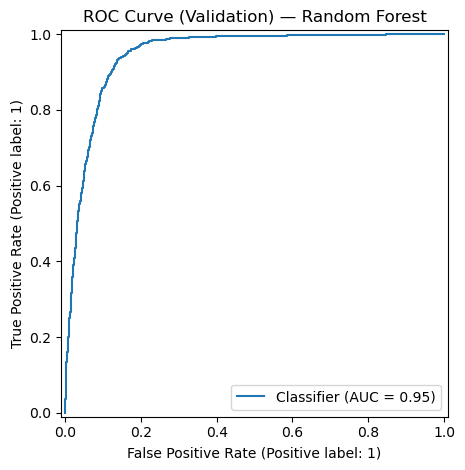

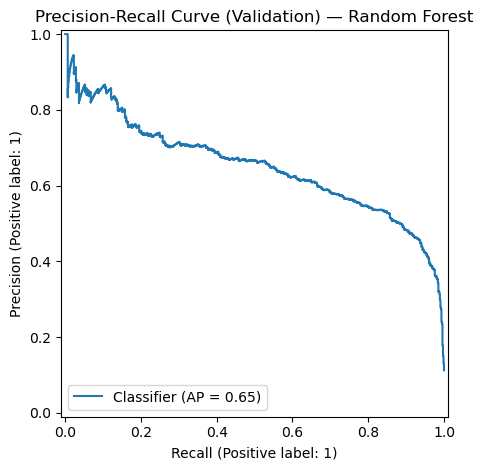


Suggested threshold for recall≥0.70: t=0.51
Precision=0.581 | Recall=0.702 | TP=521 | FP=375


In [11]:
# Select best model by validation PR-AUC
best_name = results_val.iloc[0]["model"]
best_model = models[best_name]
best_model.fit(X_train, y_train)

val_proba = best_model.predict_proba(X_val)[:, 1]
val_pred = (val_proba >= 0.5).astype(int)

print("Selected model:", best_name)
print(f"\nValidation ROC-AUC: {roc_auc_score(y_val, val_proba):.4f}")
print(f"Validation PR-AUC : {average_precision_score(y_val, val_proba):.4f}")
print("\nConfusion matrix (threshold=0.5):\n", confusion_matrix(y_val, val_pred))
print("\nClassification report:\n", classification_report(y_val, val_pred, digits=4))

# Curves
RocCurveDisplay.from_predictions(y_val, val_proba)
plt.title(f"ROC Curve (Validation) — {best_name}")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_val, val_proba)
plt.title(f"Precision-Recall Curve (Validation) — {best_name}")
plt.tight_layout()
plt.show()

# Threshold tuning: pick threshold that gives >= target recall with best precision (example)
thresholds = np.linspace(0.05, 0.95, 91)
best = None
target_recall = 0.70

for t in thresholds:
    pred_t = (val_proba >= t).astype(int)
    # Compute precision/recall manually
    cm = confusion_matrix(y_val, pred_t)
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall = tp / (tp + fn) if (tp + fn) else 0.0
    if recall >= target_recall:
        cand = (precision, recall, t, tp, fp)
        if (best is None) or (cand[0] > best[0]):
            best = cand

if best:
    precision, recall, t, tp, fp = best
    print(f"\nSuggested threshold for recall≥{target_recall:.2f}: t={t:.2f}")
    print(f"Precision={precision:.3f} | Recall={recall:.3f} | TP={tp} | FP={fp}")
else:
    print("\nNo threshold reached the target recall. Consider different model or features.")

## Generalization Check
Learning curves help verify whether performance is limited by bias (underfitting) or variance (overfitting).


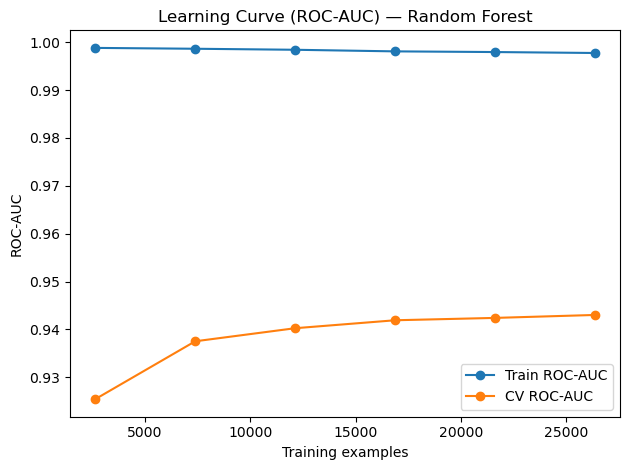

,train_size,train_roc_auc,cv_roc_auc
0,2636,0.998802,0.925432
1,7380,0.998623,0.937520
2,12125,0.998410,0.940250
3,16870,0.998076,0.941911
4,21615,0.997935,0.942404
5,26360,0.997738,0.943020


In [12]:
# Learning curve (ROC-AUC)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_model,
    X=X_trainval,
    y=y_trainval,
    cv=skf,
    scoring="roc_auc",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 6),
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, marker="o", label="Train ROC-AUC")
plt.plot(train_sizes, val_mean, marker="o", label="CV ROC-AUC")
plt.title(f"Learning Curve (ROC-AUC) — {best_name}")
plt.xlabel("Training examples")
plt.ylabel("ROC-AUC")
plt.legend()
plt.tight_layout()
plt.show()

pd.DataFrame({
    "train_size": train_sizes,
    "train_roc_auc": train_mean,
    "cv_roc_auc": val_mean
})

## Final Test Performance
After model selection, we report test-set results once for an honest estimate of generalization.


TEST ROC-AUC: 0.9523
TEST PR-AUC : 0.6938

Confusion matrix (threshold=0.5):
 [[6845  465]
 [ 232  696]]

Classification report:
               precision    recall  f1-score   support

           0     0.9672    0.9364    0.9516      7310
           1     0.5995    0.7500    0.6663       928

    accuracy                         0.9154      8238
   macro avg     0.7834    0.8432    0.8090      8238
weighted avg     0.9258    0.9154    0.9194      8238



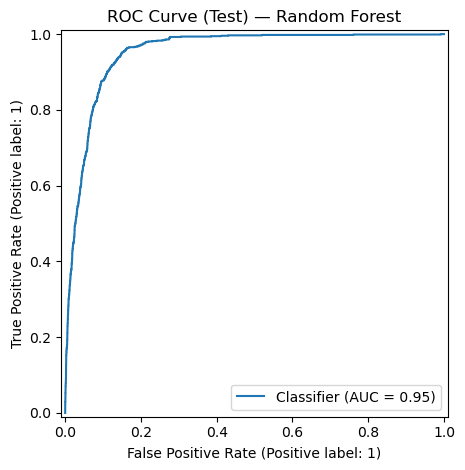

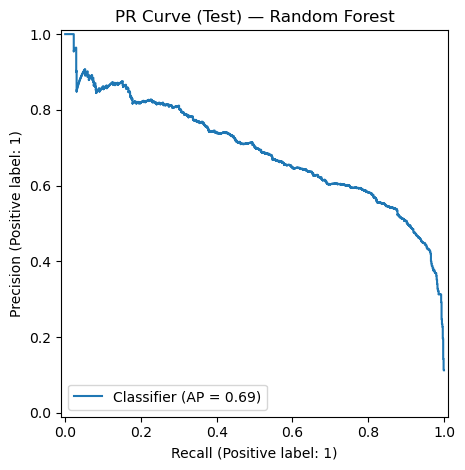

In [13]:
# Final fit on train+val, evaluate on test
best_model.fit(X_trainval, y_trainval)
test_proba = best_model.predict_proba(X_test)[:, 1]
test_pred = (test_proba >= 0.5).astype(int)

print("TEST ROC-AUC:", round(roc_auc_score(y_test, test_proba), 4))
print("TEST PR-AUC :", round(average_precision_score(y_test, test_proba), 4))
print("\nConfusion matrix (threshold=0.5):\n", confusion_matrix(y_test, test_pred))
print("\nClassification report:\n", classification_report(y_test, test_pred, digits=4))

RocCurveDisplay.from_predictions(y_test, test_proba)
plt.title(f"ROC Curve (Test) — {best_name}")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, test_proba)
plt.title(f"PR Curve (Test) — {best_name}")
plt.tight_layout()
plt.show()

## Key Drivers
Feature importance is used to surface the strongest predictors for subscription propensity.

**Takeaway:** Driver analysis is used for interpretation, not as a causal claim.


In [14]:
# Sensitivity: exclude `duration` (post-contact variable)
LEAKY_COL = "duration"
has_duration = LEAKY_COL in X.columns
print("Has duration column:", has_duration)

def build_model(drop_duration: bool):
    X2 = X.copy()
    if drop_duration and has_duration:
        X2 = X2.drop(columns=[LEAKY_COL])
    num2 = X2.select_dtypes(include=[np.number]).columns.tolist()
    cat2 = [c for c in X2.columns if c not in num2]

    preprocess2 = ColumnTransformer(
        transformers=[
            ("num", Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), num2),
            ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))]), cat2),
        ]
    )

    pipe = Pipeline(steps=[("preprocess", preprocess2),
                         ("model", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))])
    return X2, pipe

# Compare LogReg with and without duration (quick, on a single split)
X_trainval2, X_test2, y_trainval2, y_test2 = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

for drop in [False, True]:
    X2, pipe = build_model(drop_duration=drop)
    X_tr, X_te, y_tr, y_te = train_test_split(X2, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
    pipe.fit(X_tr, y_tr)
    proba = pipe.predict_proba(X_te)[:, 1]
    print(f"LogReg drop_duration={drop}: ROC-AUC={roc_auc_score(y_te, proba):.4f} | PR-AUC={average_precision_score(y_te, proba):.4f}")

Has duration column: True
LogReg drop_duration=False: ROC-AUC=0.9438 | PR-AUC=0.6222
LogReg drop_duration=True: ROC-AUC=0.8009 | PR-AUC=0.4600


,feature,importance
10,duration,0.191789
15,emp.var.rate,0.007829
18,euribor3m,0.005990
19,nr.employed,0.004383
7,contact,0.003643
8,month,0.002262
12,pdays,0.001995
4,default,0.001656
14,poutcome,0.001088
9,day_of_week,0.001065


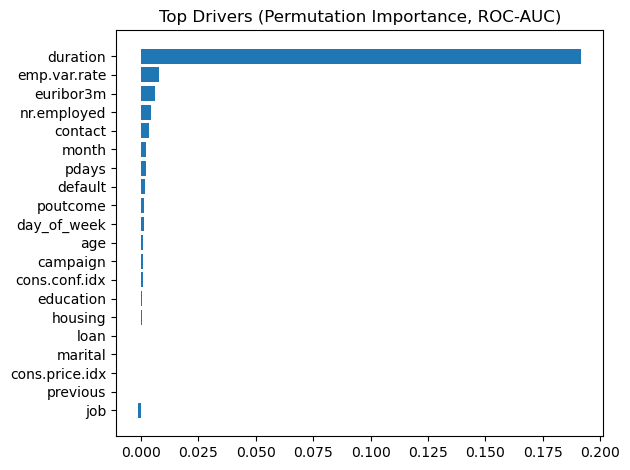

In [15]:
# Model drivers

def get_feature_names(preprocessor: ColumnTransformer):
    """Return output feature names after preprocessing (one-hot + scaling)."""
    names = []
    for name, trans, cols in preprocessor.transformers_:
        if name == "remainder":
            continue

        # If this transformer is a Pipeline, use the last step
        last = trans
        if hasattr(trans, "named_steps"):
            last = list(trans.named_steps.values())[-1]

        if hasattr(last, "get_feature_names_out"):
            names.extend(list(last.get_feature_names_out(cols)))
        else:
            names.extend(list(cols))
    return np.array(names, dtype=object)

if "Logistic Regression" in best_name:
    pre = best_model.named_steps["preprocess"]
    feat_names = get_feature_names(pre)
    clf = best_model.named_steps["model"]
    coefs = clf.coef_.ravel()
    drivers_df = pd.DataFrame({"feature": feat_names, "coef": coefs})
    imp["abs_coef"] = drivers_df["coef"].abs()
    imp = drivers_df = drivers_df.sort_values("abs_coef", ascending=False).head(25)

    display(drivers_df[["feature","coef"]])

    plt.figure()
    plt.barh(drivers_df["feature"][::-1], drivers_df["coef"][::-1])
    plt.title("Top Logistic Regression Drivers (signed coefficients)")
    plt.tight_layout()
    plt.show()
else:
    # Permutation importance on a test sample 
    X_test_sample = X_test.copy().iloc[:6000]
    y_test_sample = y_test.iloc[:6000]

    perm_result = permutation_importance(
        best_model, X_test_sample, y_test_sample,
        n_repeats=5,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        scoring="roc_auc"
    )
# permutation_importance here is for ORIGINAL input columns
    drivers_df = pd.DataFrame({
        "feature": X_test_sample.columns,
        "importance": perm_result.importances_mean
    }).sort_values("importance", ascending=False).head(25)

    display(drivers_df)

    plt.figure()
    plt.barh(drivers_df["feature"][::-1], drivers_df["importance"][::-1])
    plt.title("Top Drivers (Permutation Importance, ROC-AUC)")
    plt.tight_layout()
    plt.show()

## Business Interpretation
A simple targeting simulation illustrates how ranking customers by predicted likelihood can improve campaign efficiency vs random outreach.


In [16]:
# Score and rank test customers
scored = X_test.copy()
scored["y_true"] = y_test.values
scored["p_subscribe"] = test_proba
scored = scored.sort_values("p_subscribe", ascending=False).reset_index(drop=True)

# Example: target top 10%
top_pct = 0.10
n_target = int(len(scored) * top_pct)
target = scored.head(n_target)

base_rate = scored["y_true"].mean()
hit_rate = target["y_true"].mean()

print(f"Base subscribe rate: {base_rate:.3f}")
print(f"Top {top_pct:.0%} target group subscribe rate: {hit_rate:.3f}")
print(f"Lift: {hit_rate / base_rate:.2f}x")

display(target.head(10))

# Simple ROI simulation (edit assumptions)
cost_per_contact = 1.0          # e.g., call/SMS/email cost in currency units
profit_per_conversion = 50.0    # expected profit (or value) from a successful subscription

# Target strategy metrics
n_total = len(scored)
n_target = len(target)
tp_target = (target["y_true"] == 1).sum()
conv_rate_target = tp_target / n_target

expected_profit_target = tp_target * profit_per_conversion - n_target * cost_per_contact

# Random targeting baseline (same number of contacts, expected conversions = base_rate * n_target)
expected_conv_random = base_rate * n_target
expected_profit_random = expected_conv_random * profit_per_conversion - n_target * cost_per_contact

print("\n--- ROI simulation ---")
print(f"Total clients in test set: {n_total:,}")
print(f"Contacts (top {top_pct:.0%}): {n_target:,}")
print(f"Observed conversions in target group: {tp_target:,} (rate={conv_rate_target:.3f})")
print(f"Expected profit (targeting): {expected_profit_target:,.2f}")

print(f"Expected conversions (random): {expected_conv_random:,.1f} (rate={base_rate:.3f})")
print(f"Expected profit (random): {expected_profit_random:,.2f}")

uplift = expected_profit_target - expected_profit_random
print(f"Estimated profit uplift vs random: {uplift:,.2f}")


Base subscribe rate: 0.113
Top 10% target group subscribe rate: 0.655
Lift: 5.81x


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y_true,p_subscribe
0,34,admin.,single,university.degree,no,no,no,cellular,mar,tue,...,6,1,success,-1.8,93.369,-34.8,0.652,5008.7,1,0.987774
1,33,admin.,married,university.degree,no,yes,no,cellular,aug,thu,...,3,3,success,-1.7,94.027,-38.3,0.899,4991.6,1,0.980501
2,37,admin.,married,university.degree,no,no,no,cellular,sep,wed,...,6,2,success,-1.1,94.199,-37.5,0.886,4963.6,1,0.979173
3,52,management,married,university.degree,no,yes,no,cellular,may,fri,...,3,3,success,-1.8,93.876,-40.0,0.684,5008.7,1,0.971007
4,66,admin.,divorced,university.degree,no,yes,no,cellular,aug,wed,...,6,2,success,-1.7,94.027,-38.3,0.903,4991.6,1,0.970312
5,59,retired,married,professional.course,no,yes,no,cellular,aug,fri,...,3,2,success,-1.7,94.027,-38.3,0.905,4991.6,1,0.968112
6,42,technician,married,professional.course,no,no,no,cellular,aug,thu,...,6,2,success,-1.7,94.027,-38.3,0.899,4991.6,1,0.967770
7,76,retired,married,basic.4y,no,yes,no,cellular,may,fri,...,6,2,success,-1.8,93.876,-40.0,0.684,5008.7,1,0.966190
8,50,admin.,single,university.degree,no,no,no,cellular,aug,tue,...,6,2,success,-1.7,94.027,-38.3,0.904,4991.6,1,0.965442
9,33,admin.,married,university.degree,no,yes,no,cellular,may,mon,...,3,2,success,-1.8,93.876,-40.0,0.685,5008.7,1,0.965419



--- ROI simulation ---
Total clients in test set: 8,238
Contacts (top 10%): 823
Observed conversions in target group: 539 (rate=0.655)
Expected profit (targeting): 26,127.00
Expected conversions (random): 92.7 (rate=0.113)
Expected profit (random): 3,812.49
Estimated profit uplift vs random: 22,314.51


## Limitations & Next Steps
- Cost-sensitive optimization was not applied (thresholding is a first step).
- Temporal validation could better reflect real campaign deployment.
- Next: package preprocessing + model as a batch scoring script or lightweight API.
